# Data Mining Coursework 2
This Jupyter Notebook contains code that performs the following operations:
1. Data Exploration, Visualisation, and Summary
2. Data Cleansing and Pre-processing
3. Supervised Model Training, Tuning, and Evaluation
4. Unsupervised Learning using Clustering Algorithms

## Prior setups
Importing the necessary libraries and relevant folder and files.

In [1]:
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import nan
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
# The types of classifiers to use
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# 2 kinds of sampling techniques to use
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

print("Setup complete.")

data_folder = "data/"
train_data_file = "disease_train.csv"
test_data_file = "disease_test.csv"
prediction_data_file = "predictedTarget.csv"

Setup complete.


Read the CSV files and store the data into a Pandas DataFrame.

In [2]:
train_data = pd.read_csv(data_folder + train_data_file, delimiter=",")
test_data = pd.read_csv(data_folder + test_data_file, delimiter=",")
print(train_data.head(10))
print(test_data.head(10))

       id  age  gender sick pregnant  test_X1  test_X2  test_X3  test_X4  \
0  PA1001   59    male   no       no      7.8      NaN     89.0     0.85   
1  PA1002   48  female   no       no      1.5      2.5    101.0     0.97   
2  PA1003   77    male   no       no      7.3      1.2     57.0     1.28   
3  PA1004   42  female   no       no      1.2      2.5    106.0     0.98   
4  PA1005   38  female   no       no      0.6      1.9     95.0      NaN   
5  PA1006   44    male   no       no      3.0      2.0    115.0     1.10   
6  PA1007   90  female   no       no      1.5      1.8     98.0     0.94   
7  PA1008   69  female   no       no      6.9      NaN    109.0     1.03   
8  PA1009   33  female   no       no      0.1      1.7    104.0     0.80   
9  PA1010   42  female   no       no      1.9      2.2    126.0     0.97   

   test_X5  ...  tumor disorder medication_A medication_B mental_health  \
0    105.0  ...     no       no           no           no            no   
1    104.0  .

## 1. Data Exploration, Visualisation, and Summary
As the data mining procedure mainly involves the training data, most of the operations will be solely done on the training data and the test data will follow suit.

In the cell below, the names of the categorical and numerical columns are obtained and stored in a list. This method avoids writing them down manually. As `test_data` does not have the `target` column, `target` will be removed from the DataFrame and will be instead stored in a separate variable that acts as the target label for Operations 3 and 4.

In [3]:
train_categorical_columns = list(train_data.select_dtypes(include=["object"]).columns)
train_numerical_columns = list(train_data.select_dtypes(include=["int64", "float64"]).columns)
print(f"train_categorical_columns = {train_categorical_columns}")
print(f"train_numerical_columns = {train_numerical_columns}\n")
test_categorical_columns = list(test_data.select_dtypes(include=["object"]).columns)
test_numerical_columns = list(test_data.select_dtypes(include=["int64", "float64"]).columns)
print(f"test_categorical_columns = {test_categorical_columns}")
print(f"test_numerical_columns = {test_numerical_columns}")

train_categorical_columns = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect', 'target']
train_numerical_columns = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']

test_categorical_columns = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect']
test_numerical_columns = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']


Get a statistical summary of the numerical features.

In [4]:
print(f"Train data summary statistics: \n{train_data.describe()}")
print("\n")
print(f"Test data summary statistics: \n{test_data.describe()}")

Train data summary statistics: 
                age      test_X1      test_X2      test_X3      test_X4  \
count   4250.000000  3839.000000  3007.000000  4034.000000  3858.000000   
mean      67.374824     7.342463     2.035580   104.919623     0.970846   
std     1004.518821    32.657963     0.920404    35.496255     0.162474   
min        1.000000     0.005000     0.050000     2.000000     0.250000   
25%       37.000000     0.600000     1.600000    87.000000     0.870000   
50%       55.000000     1.500000     1.900000   102.000000     0.960000   
75%       67.000000     3.000000     2.300000   121.000000     1.060000   
max    65526.000000   530.000000    18.000000   430.000000     1.960000   

           test_X5     test_X6  
count  3863.000000  154.000000  
mean    110.090834   23.325974  
std      39.837621    5.317032  
min       1.400000    8.400000  
25%      92.000000   20.000000  
50%     107.000000   24.000000  
75%     125.000000   27.000000  
max     642.000000   45.0000

Check the data type of the columns and check how many entries are non-null in the training data. 60% of the total entries have to be non-null for a feature in order for a feature to be valid. 60% of 4250 is 2550. Looking at the columns, column `test_X6` has less than 2550 entries that are non-null values. Hence, column `text_X6` can be removed from the dataset.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4250 non-null   object 
 1   age              4250 non-null   int64  
 2   gender           4109 non-null   object 
 3   sick             4250 non-null   object 
 4   pregnant         4250 non-null   object 
 5   test_X1          3839 non-null   float64
 6   test_X2          3007 non-null   float64
 7   test_X3          4034 non-null   float64
 8   test_X4          3858 non-null   float64
 9   test_X5          3863 non-null   float64
 10  test_X6          154 non-null    float64
 11  concern_type1    4250 non-null   object 
 12  concern_type2    4250 non-null   object 
 13  enlargement      4250 non-null   object 
 14  tumor            4250 non-null   object 
 15  disorder         4250 non-null   object 
 16  medication_A     4250 non-null   object 
 17  medication_B  

The cell below counts the total occurrances for each value in every column. The column `id` has only unique values and column `disorder` is constant for all entries, meaning that both can be safely removed from the dataset. 

Some columns contains outliers which will need to be preproccessed later like `age` which not only has outrageous outliers. Some columns have highly imbalanced data which will also need to be accounted for.

In [6]:
for column in train_data.columns:
    print(train_data[column].value_counts(), "\n")

PA1001    1
PA3839    1
PA3825    1
PA3826    1
PA3827    1
         ..
PA2423    1
PA2424    1
PA2425    1
PA2426    1
PA5250    1
Name: id, Length: 4250, dtype: int64 

59       100
62        97
60        94
58        93
55        89
        ... 
65526      1
4          1
97         1
455        1
94         1
Name: age, Length: 94, dtype: int64 

female    2787
male      1322
Name: gender, dtype: int64 

no     4095
yes     155
Name: sick, dtype: int64 

no     4235
yes      15
Name: pregnant, dtype: int64 

0.100      117
1.300      109
1.500      106
1.100      104
1.200      104
          ... 
164.000      1
0.255        1
170.000      1
56.000       1
165.000      1
Name: test_X1, Length: 334, dtype: int64 

1.8    237
2.0    231
1.9    223
1.7    209
2.1    191
      ... 
5.6      1
6.4      1
5.4      1
4.8      1
6.9      1
Name: test_X2, Length: 77, dtype: int64 

101.0    91
98.0     81
95.0     78
93.0     78
90.0     71
         ..
359.0     1
18.0      1
27.0      1
218.

Check if there are any outrageous outliers in age. We can assume 100 is the maximum age.

In [7]:
print(train_data[train_data["age"] > 100])
print(test_data[train_data["age"] > 100])

          id    age  gender sick pregnant  test_X1  test_X2  test_X3  test_X4  \
2459  PA3460  65526  female   no       no      1.5      NaN    132.0     1.02   
3477  PA4478    455  female   no       no      1.1      2.0    118.0     1.13   

      test_X5  ...  tumor disorder medication_A medication_B mental_health  \
2459    129.0  ...     no       no           no           no            no   
3477    104.0  ...     no       no           no           no            no   

     mood_stabiliser surgery treatment_type1 suspect    target  
2459              no      no              no      no  low_risk  
3477              no      no              no      no  low_risk  

[2 rows x 24 columns]
Empty DataFrame
Columns: [id, age, gender, sick, pregnant, test_X1, test_X2, test_X3, test_X4, test_X5, test_X6, concern_type1, concern_type2, enlargement, tumor, disorder, medication_A, medication_B, mental_health, mood_stabiliser, surgery, treatment_type1, suspect]
Index: []

[0 rows x 23 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_11240\497109122.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_data[train_data["age"] > 100])


The distribution of the plot below clearly shows a highly imbalanced dataset. 

<AxesSubplot:xlabel='target', ylabel='count'>

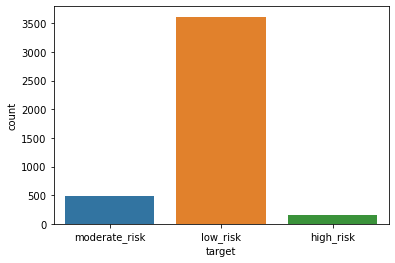

In [8]:
sns.countplot(x='target', data=train_data)

The cell below creates plots showing distribution for almost every column against `target` except `id`, `disorder`, and `target` as they only have unique values, constant values, and same values respectively. While the data is not sparse, the distribution of data of many columns show that it is very imbalanced.

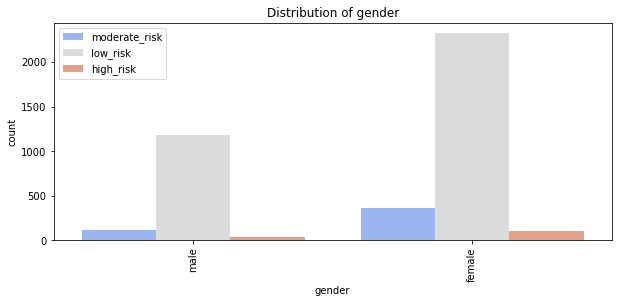

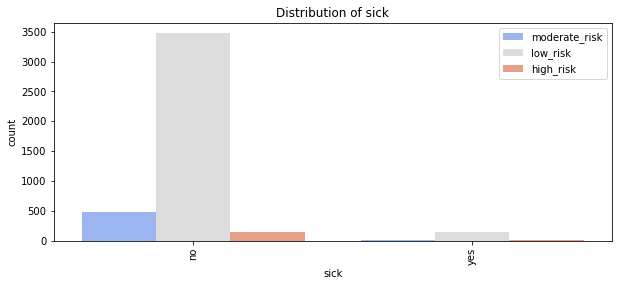

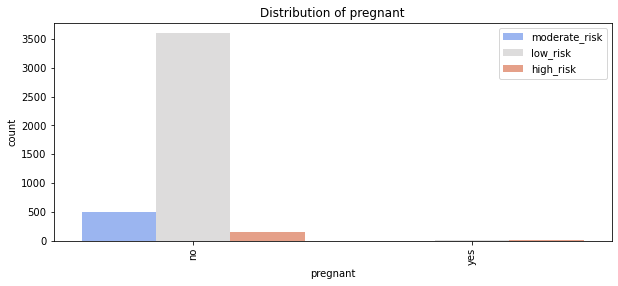

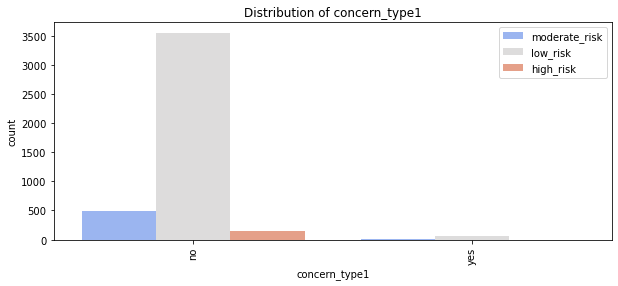

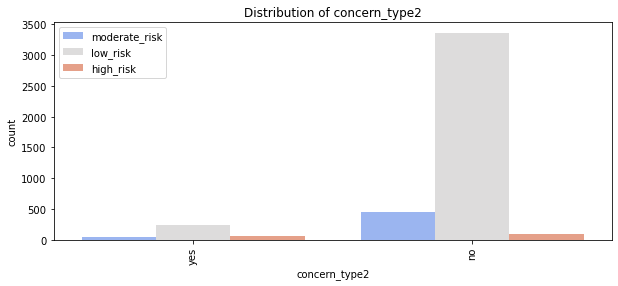

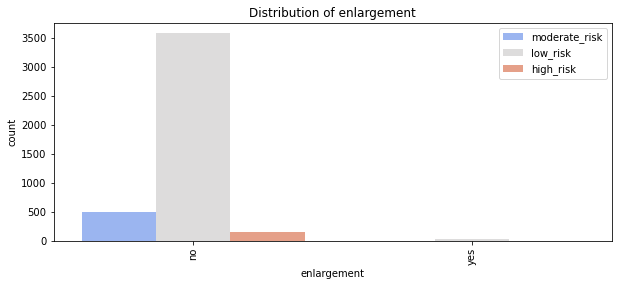

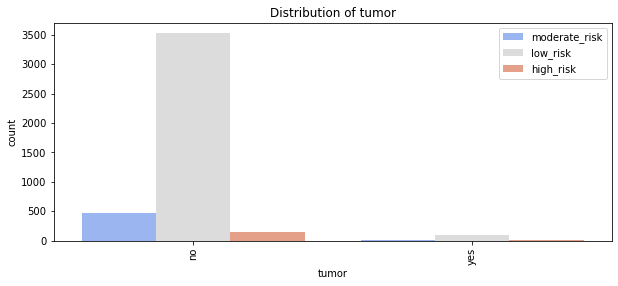

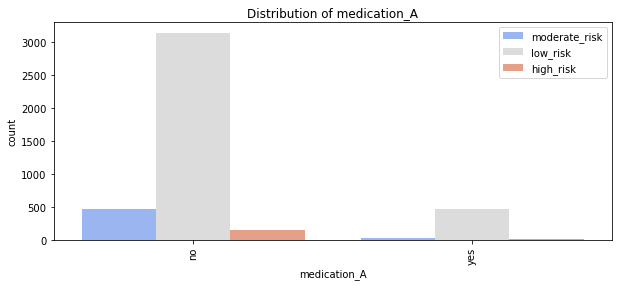

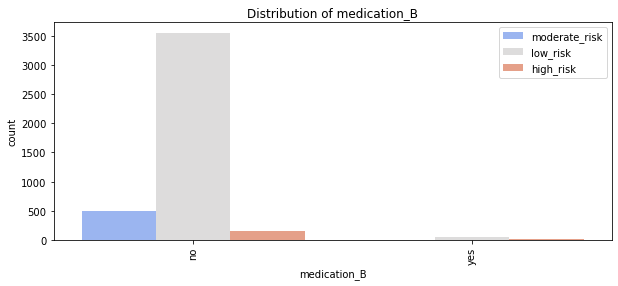

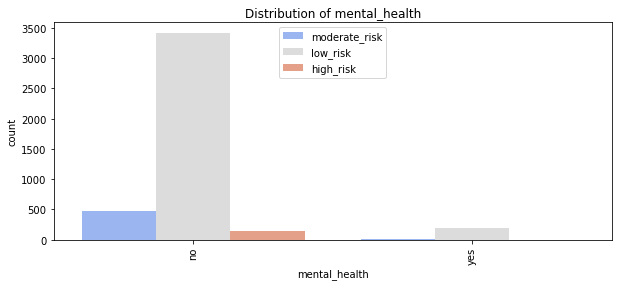

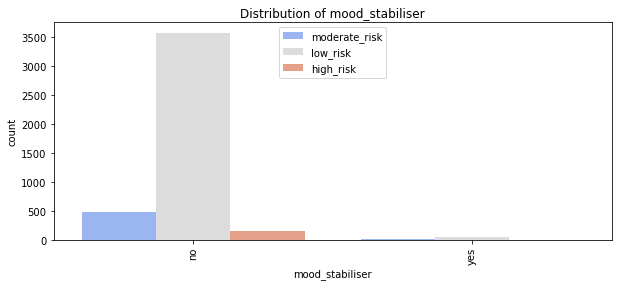

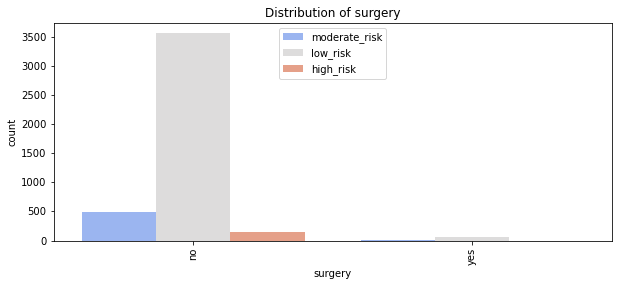

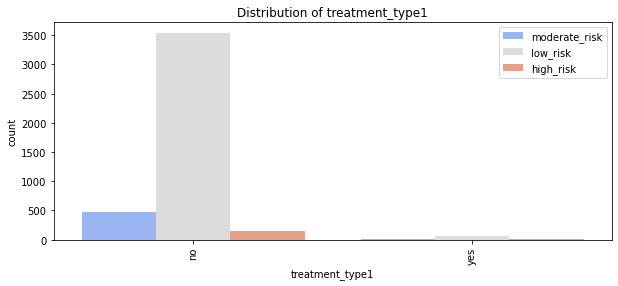

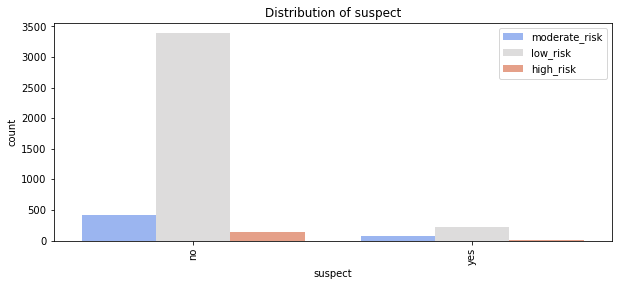

In [9]:
for column in train_categorical_columns:
    if column in ["id", "disorder", "target"]:
        continue
    #make sure that plot only takes the two plots below by using the following command
    plt.figure(figsize=(10,4))
    plt.xticks(rotation=90) 
    sns.countplot(x=column, hue='target', palette="coolwarm", data=train_data)
    #include a legend
    plt.legend()
    #include a dynamic title
    plt.title("Distribution of " +column)
    #Save the plot to the working directory
    plt.savefig(data_folder+column+'.jpg')

Boxplots can be plotted using a categorical column against all numerical columns by changing the value of the `cat` variable. The categorical columns that can be used are `gender`, `sick`, `pregnant`, `concern_type1`, `concern_type2`, `enlargement`, `tumor`, `medication_A`, `medication_B`, `mental_health`, `mood_stabiliser`, `surgery`, `treatment_type1`, `suspect`.

In [ ]:
cat = "gender"
for num in train_numerical_columns:
    if num == "test_X6" or cat in ["id", "disorder", "target"]:
        continue
    sns.catplot(x=cat, y=num, hue="target",  kind="box", data=train_data)
    #include a legent
    plt.legend()
    #include a dynamic title
    plt.title("Boxplot of " + cat + " against " + num)
    #Save the plot to the working directory
    plt.savefig(data_folder + cat + "_vs_"+ num +'.jpg')

In [10]:
# get the number of missing data points per column
missing_values_count = train_data.isnull().sum()

# look at the # of missing points in the  columns
print(missing_values_count)


id                    0
age                   0
gender              141
sick                  0
pregnant              0
test_X1             411
test_X2            1243
test_X3             216
test_X4             392
test_X5             387
test_X6            4096
concern_type1         0
concern_type2         0
enlargement           0
tumor                 0
disorder              0
medication_A          0
medication_B          0
mental_health         0
mood_stabiliser       0
surgery               0
treatment_type1       0
suspect               0
target                0
dtype: int64


## 2. Data Cleansing and Pre-processing
Store the target labels in a separate variable and remove the unnecessary columns. As `suspect` is given by the patients and not a physical or mental status, it is safe to assume that it is a feature not worth exploring.

In [ ]:
target_labels = train_data["target"]
train_data.drop(columns=["id", "test_X6", "disorder", "suspect"], inplace=True)
test_data.drop(columns=["id", "test_X6", "disorder", "suspect"], inplace=True)

In [ ]:
print(train_data)
print(test_data)